In [9]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk as nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
print('Import Successfull')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Import Successfull


In [11]:
#Importing stock prices Data-Set
stock_price = pd.read_csv('/content/^BSESN.csv')
print('Data Import Successful')

Data Import Successful


In [ ]:
stock_price.head()

,Close,Open,High,Low,Volume
Date,,,,,
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0


In [12]:
stock_headlines = pd.read_csv('/content/india-news-headlines.csv')

In [13]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [14]:
len(stock_price), len(stock_headlines)

(4003, 3424067)

In [15]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

**Stock Prices**

In [16]:
stock_price.dropna(axis = 0, inplace = True)

In [17]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0
...,...,...,...,...,...
2021-03-05,50405.320313,50517.359375,50886.191406,50160.539063,19200.0
2021-03-08,50441.070313,50654.019531,50985.769531,50318.261719,14200.0
2021-03-09,51025.480469,50714.160156,51111.941406,50396.101563,12200.0


**Stock Headlines**

In [18]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [19]:
stock_data = pd.concat([stock_price, stock_headlines], axis = 1)
stock_data.dropna(axis = 0, inplace = True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur..."
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S..."
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f..."
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M..."
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,..."
...,...,...,...,...,...,...
2020-12-24,46973.539063,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851563,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


In [20]:
#Sentiment Analysis:-
stock_data['coumpound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,coumpound,negative,neutral,positive
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur...",,,,
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",,,,
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f...",,,,
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M...",,,,
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",,,,


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,coumpound,negative,neutral,positive,compound
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur...",,0.114,0.802,0.084,-0.9731
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",,0.062,0.880,0.059,-0.7600
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f...",,0.110,0.805,0.085,-0.9757
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M...",,0.073,0.825,0.102,0.9417
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",,0.087,0.836,0.076,-0.9456


In [23]:
stock_data.drop(['headline_text'], inplace = True, axis = 1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,6679.200195,-0.9731,0.114,0.802,0.084,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,-0.7600,0.062,0.880,0.059,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,-0.9757,0.110,0.805,0.085,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,0.9417,0.073,0.825,0.102,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,-0.9456,0.087,0.836,0.076,6374.189941,6440.169922,6348.750000,17800.0


**Feature Engineering of the Combined Data**

In [24]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [25]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3.924000e+03
mean,22298.458085,-0.904143,0.128401,0.784846,0.086764,22323.202845,22455.392965,22146.645710,9.799867e+04
std,9548.368404,0.402293,0.021218,0.027104,0.015803,9565.093295,9585.146826,9516.588063,1.194171e+06
min,6102.740234,-1.000000,0.038000,0.637000,0.029000,6093.660156,6174.000000,6069.330078,8.000000e+02
25%,15687.654786,-0.999800,0.115000,0.766000,0.077000,15693.625000,15833.409912,15478.495361,1.077500e+04
50%,19598.490235,-0.999500,0.129000,0.782000,0.086000,19602.250000,19726.554688,19460.065430,1.445000e+04
75%,28722.527832,-0.997400,0.142000,0.801000,0.096250,28800.262207,28884.082032,28566.407227,2.020000e+04
max,47751.328125,1.000000,0.216000,0.903000,0.253000,47789.031250,47896.968750,47602.121094,3.181510e+07


In [26]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2005-01-03 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     3924 non-null   float64
 1   compound  3924 non-null   float64
 2   negative  3924 non-null   float64
 3   neutral   3924 non-null   float64
 4   positive  3924 non-null   float64
 5   Open      3924 non-null   float64
 6   High      3924 non-null   float64
 7   Low       3924 non-null   float64
 8   Volume    3924 non-null   float64
dtypes: float64(9)
memory usage: 306.6 KB


**Stock Data Analysis**

Text(0, 0.5, 'Close Price(INR')

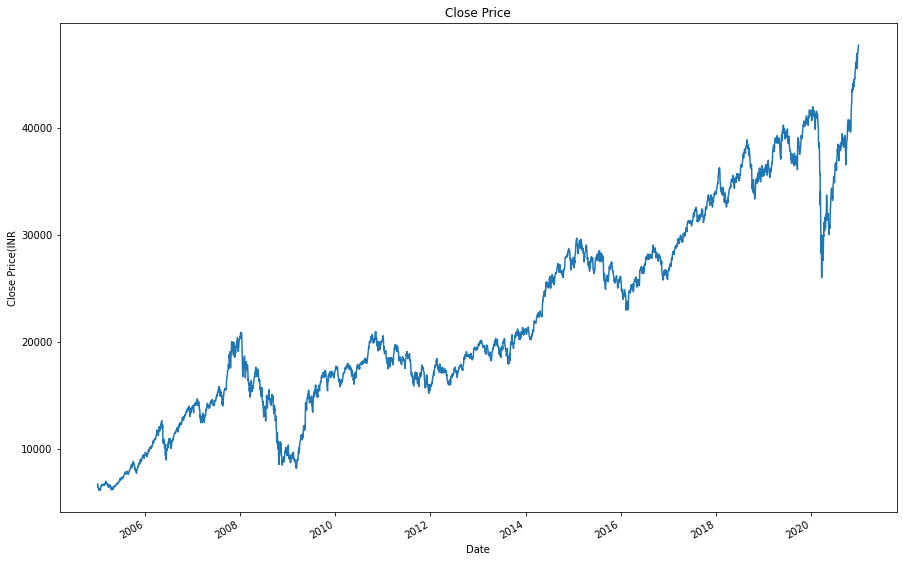

In [28]:
plt.figure(figsize = (15,10))
stock_data['Close'].plot()
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel("Close Price(INR")

In [29]:
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-11,6444.044294,-0.389857,0.090429,0.821714,0.087857,6502.588658,6532.984305,6396.397112,17428.571429
2005-01-12,6361.692871,-0.387243,0.089429,0.822143,0.088429,6448.854353,6472.911412,6316.945661,18685.714286
2005-01-13,6300.271484,-0.350286,0.094571,0.810714,0.094429,6370.924317,6408.145717,6245.109933,19200.000000
2005-01-14,6259.554339,-0.099329,0.086571,0.821714,0.091429,6314.285714,6353.775739,6217.462821,18371.428571


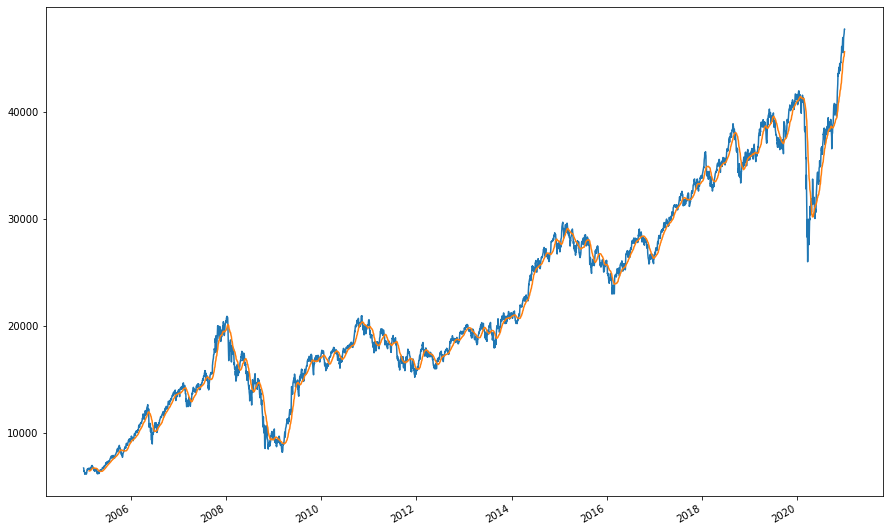

In [30]:
plt.figure(figsize=(15,10))
stock_data['Close'].plot()
stock_data.rolling(window = 30).mean()['Close'].plot()

In [31]:
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,6679.200195,-0.9731,0.114,0.802,0.084,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,-0.7600,0.062,0.880,0.059,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,-0.9757,0.110,0.805,0.085,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,0.9417,0.073,0.825,0.102,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,-0.9456,0.087,0.836,0.076,6374.189941,6440.169922,6348.750000,17800.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,46973.539063,-0.9966,0.080,0.857,0.063,46743.488281,47053.398438,46539.019531,13700.0
2020-12-28,47353.750000,-0.9997,0.125,0.792,0.083,47153.589844,47406.718750,47148.238281,9600.0
2020-12-29,47613.078125,-0.9997,0.134,0.777,0.089,47466.621094,47714.550781,47361.898438,12800.0
2020-12-30,47746.218750,-0.9997,0.122,0.802,0.076,47789.031250,47807.851563,47358.359375,15600.0


**Data For Modelling**

In [33]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use
print("Number of records in Training Data: ", train_end)
print("Number of records in Test Data: ", total_data - train_end)

Number of records in Training Data:  3138
Number of records in Test Data:  786


In [34]:
steps_to_predict = 1
close_price = stock_data.iloc[start:total_data,0]#Close
compound = stock_data.iloc[start:total_data,1]#compound
negative = stock_data.iloc[start:total_data,2]#neg
neutral = stock_data.iloc[start:total_data,3]#neu
positive = stock_data.iloc[start:total_data,4]#pos
open_price = stock_data.iloc[start:total_data,5]#open
high = stock_data.iloc[start:total_data,6]#high
low = stock_data.iloc[start:total_data,7]#low
volume = stock_data.iloc[start:total_data,8]#volume
print('Close price:')
close_price

Close price:


2005-01-04     6651.009766
2005-01-05     6458.839844
2005-01-06     6367.390137
2005-01-07     6420.459961
2005-01-10     6308.540039
                  ...     
2020-12-24    46973.539063
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: Close, Length: 3923, dtype: float64

In [37]:
close_price_shifted = close_price.shift(-1) 
compound_shifted = compound.shift(-1) 
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,6458.839844,-0.7600,-0.9757,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,6367.390137,-0.9757,0.9417,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,6420.459961,0.9417,-0.9456,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,6308.540039,-0.9456,0.9673,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,6222.870117,0.9673,-0.9836,13200.0,6440.330078,6469.089844,6286.850098
2005-01-11,6222.870117,6102.740234,-0.9836,-0.9548,16200.0,6317.390137,6329.890137,6208.819824
2005-01-12,6102.740234,6221.060059,-0.9548,-0.5013,20800.0,6250.350098,6263.709961,6070.330078
2005-01-13,6221.060059,6173.819824,-0.5013,0.7810,20200.0,6138.049805,6242.950195,6138.049805
2005-01-14,6173.819824,6194.069824,0.7810,-0.9925,18200.0,6232.419922,6249.390137,6144.080078
2005-01-17,6194.069824,6192.350098,-0.9925,-0.9990,19000.0,6202.740234,6232.970215,6087.549805


In [38]:
y = data['close_price_shifted']
y

2005-01-04     6458.839844
2005-01-05     6367.390137
2005-01-06     6420.459961
2005-01-07     6308.540039
2005-01-10     6222.870117
                  ...     
2020-12-23    46973.539063
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 3922, dtype: float64

In [39]:
cols = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,6458.839844,-0.7600,-0.9757,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,6367.390137,-0.9757,0.9417,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,6420.459961,0.9417,-0.9456,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,6308.540039,-0.9456,0.9673,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,6222.870117,0.9673,-0.9836,13200.0,6440.330078,6469.089844,6286.850098
...,...,...,...,...,...,...,...,...
2020-12-23,46444.179688,46973.539063,-0.9995,-0.9966,10500.0,46072.300781,46513.320313,45899.101563
2020-12-24,46973.539063,47353.750000,-0.9966,-0.9997,13700.0,46743.488281,47053.398438,46539.019531
2020-12-28,47353.750000,47613.078125,-0.9997,-0.9997,9600.0,47153.589844,47406.718750,47148.238281
2020-12-29,47613.078125,47746.218750,-0.9997,-0.9997,12800.0,47466.621094,47714.550781,47361.898438


In [40]:
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1))
x = np.array(x).reshape(len(x), len(cols))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler(feature_range=(-1,1))
y = np.array(y).reshape(len(y), 1)
y = scaler_y.fit_transform(y)
x,y

(array([[-0.97366841, -0.9828998 , -0.76      , ..., -0.9717043 ,
         -0.97490936, -0.97231609],
        [-0.9828977 , -0.98729129, -0.9757    , ..., -0.97432665,
         -0.97809571, -0.9870059 ],
        [-0.98728973, -0.98474283,  0.9417    , ..., -0.98303841,
         -0.98524134, -0.98759923],
        ...,
        [ 0.98115101,  0.99336112, -0.9997    , ...,  0.96951981,
          0.98073045,  0.9896514 ],
        [ 0.99360569,  0.99975464, -0.9997    , ...,  0.98453497,
          0.99551803,  1.        ],
        [ 1.        ,  1.        , -0.9997    , ...,  1.        ,
          1.        ,  0.99982859]]), array([[-0.9828998 ],
        [-0.98729129],
        [-0.98474283],
        ...,
        [ 0.99336112],
        [ 0.99975464],
        [ 1.        ]]))

**Data divided for training and test datasets**

In [41]:
X_train = x[0:train_end,]
X_test = x[train_end+1 : len(x),]
y_train = y[0:train_end,]
y_test = y[train_end+1 : len(y),]

print("Number of rows and columns in Training Set X: ", X_train.shape, 'and y:', y_train.shape)
print("Number of rows and columns in Test Set X:", X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training Set X:  (3138, 8) and y: (3138, 1)
Number of rows and columns in Test Set X: (783, 8) and y: (783, 1)


**Data Modelling**

In [44]:
np.random.seed(2016)
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8, 100)            40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 100)            80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                